### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
env = CabDriver()

In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.05
        self.epsilon_max = 1.0
        self.epsilon = 1.0
        self.epsilon_decay = 0.99999
        self.epsilon_min = 0.1
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # initialize target model
        self.update_target_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        
        model.summary()
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        return model



    def get_action(self, state, possible_actions_index):
        state = np.reshape(state,(1,self.state_size))
        
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon:
            x = random.randrange(len(possible_actions_index))
            return (possible_actions_index[x])
        
        # if generated random number is greater than ε, choose the action which has max Q-value
        else:
            q_value = self.model.predict(state)
            #print(q_value.shape)
#             new_q_value = q_value[0][possible_actions_index]
            
#             return np.argmax(new_q_value)
            new_q_value = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(new_q_value)]


    

    def append_sample(self, state, action, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
                # Adding sample to the memory. 
        self.memory.append((state, action, reward, next_state, done))
        
        # Decay in ε after we generate each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    
    def update_target_model(self):
        '''
        TODO:
        Update the target Q-value network to current Q-value network after training for a episode. This means that weights an
        biases of target Q-value network will become same as current Q-value network.
        '''
        self.target_model.set_weights(self.model.get_weights())

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory

            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size))# write here
            actions, rewards, done_list = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done = mini_batch[i]
                update_input[i] = env.state_encod_arch2(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch2(next_state)
                done_list.append(done)

                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            
                
            # 2. Get the target for the Q-network
            target_val = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
                    # R_t + γ ∗ max Q_t(S_{t+1},a)−Q_t(S_t,a_t)
            for i in range(self.batch_size):
                # Q Learning: get maximum Q value at s' from target model
                if done_list[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size,epochs=1, verbose=0)


    def save(self, name):
        self.model.save_weights(name)

In [6]:
Episodes = 10000

In [7]:
# state = [0,0,0]
# agent = DQNAgent(state_size, action_size)
# encoded_state = env.state_encod_arch2(state)
# possible_actions_index,actions = env.requests(state)
# action = agent.get_action(encoded_state,possible_actions_index)

### DQN block

In [8]:
env = CabDriver()
# Call all the initialised variables of the environment

# Defining hyperparameters
m = 5 # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
C = 5 # Per hour fuel and other costs
R = 9 # per hour revenue from a passenger

# Call the environment

state_size = m+t+d
action_size = len(env.action_space)

#Call the DQN agent
agent = DQNAgent(state_size, action_size)
scores, episodes = [], []

for e in range(Episodes):
    done = False
    score = 0
    state_space,action_space,state = env.reset()
    encoded_state = env.state_encod_arch2(state)
    
    while env.time_elapsed < 24*30:
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_index,actions = env.requests(state)
        action = agent.get_action(encoded_state,possible_actions_index)
        
        # 2. Evaluate your reward and next state
        next_state = env.next_state_func(state,action,Time_matrix)
        reward = env.reward_func(state,action,Time_matrix)
        done = False
#         print(next_state)
        encoded_next_state = env.state_encod_arch2(next_state)
        
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state, done)
        
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
            
        score += reward
        state = next_state

        if env.time_elapsed >= 24*30 :
            agent.update_target_model()
            scores.append(score)
            episodes.append(e)
            print("episode:", e, "  score:", score, "  memory length:",
            len(agent.memory), "  epsilon:", agent.epsilon)
            
#             if np.mean(scores[-min(30, len(scores)):]) > 490:
#                 agent.model.save_weights("/content/gdrive/My Drive/ColabNotebooks/Practical_RL/DQN/Cartpole/save_model/cartpole_dqn.h5")
#                 sys.exit()

        # 5. Keep a track of rewards, Q-values, loss
    if e % 50 == 0:
        file1 = open("scores.txt","w")
        for i in scores:
            file1.write(str(i) + "\n")
        agent.model.save_weights("temp.h5")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1184      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 21)                693       
                                                                 
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                1184      
                                                                 
 dense_4 (Dense)             (No

C:\Users\kanig\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


episode: 0   score: 55.0   memory length: 82   epsilon: 0.9991803320114612
episode: 1   score: 36.0   memory length: 167   epsilon: 0.9983313853379648
episode: 2   score: -171.0   memory length: 234   epsilon: 0.997662723993043
episode: 3   score: -167.0   memory length: 302   epsilon: 0.9969845405583089
episode: 4   score: -160.0   memory length: 375   epsilon: 0.9962570037892448
episode: 5   score: -241.0   memory length: 438   epsilon: 0.995629556406297
episode: 6   score: -113.0   memory length: 503   epsilon: 0.9949826042421016
episode: 7   score: -10.0   memory length: 574   epsilon: 0.9942764137894118
episode: 8   score: -196.0   memory length: 643   epsilon: 0.993590596269061
episode: 9   score: -193.0   memory length: 704   epsilon: 0.9929846877966649
episode: 10   score: -21.0   memory length: 779   epsilon: 0.9922402247670328
episode: 11   score: -257.0   memory length: 833   epsilon: 0.9917045570106284
episode: 12   score: 34.0   memory length: 901   epsilon: 0.991030423772

episode: 105   score: 13.0   memory length: 2000   epsilon: 0.9319553694009295
episode: 106   score: 63.0   memory length: 2000   epsilon: 0.9312659740883187
episode: 107   score: 54.0   memory length: 2000   epsilon: 0.9306050066130959
episode: 108   score: -198.0   memory length: 2000   epsilon: 0.9299352088154852
episode: 109   score: -9.0   memory length: 2000   epsilon: 0.929275185852987
episode: 110   score: 76.0   memory length: 2000   epsilon: 0.9286527768967021
episode: 111   score: 197.0   memory length: 2000   epsilon: 0.9280493457109426
episode: 112   score: -174.0   memory length: 2000   epsilon: 0.9273999352420716
episode: 113   score: -186.0   memory length: 2000   epsilon: 0.9268065862087131
episode: 114   score: -3.0   memory length: 2000   epsilon: 0.9261858306685005
episode: 115   score: -147.0   memory length: 2000   epsilon: 0.9255932584173563
episode: 116   score: 178.0   memory length: 2000   epsilon: 0.9249363171609144
episode: 117   score: -18.0   memory length

episode: 208   score: -44.0   memory length: 2000   epsilon: 0.8708455076015476
episode: 209   score: -208.0   memory length: 2000   epsilon: 0.8702709363230509
episode: 210   score: -27.0   memory length: 2000   epsilon: 0.8696967441383788
episode: 211   score: -5.0   memory length: 2000   epsilon: 0.8690794755199852
episode: 212   score: 229.0   memory length: 2000   epsilon: 0.868506069443929
episode: 213   score: -151.0   memory length: 2000   epsilon: 0.8680024794609119
episode: 214   score: -78.0   memory length: 2000   epsilon: 0.8673950873003843
episode: 215   score: -63.0   memory length: 2000   epsilon: 0.8668834725819845
episode: 216   score: 193.0   memory length: 2000   epsilon: 0.8663634959071519
episode: 217   score: 14.0   memory length: 2000   epsilon: 0.8658005398005849
episode: 218   score: -190.0   memory length: 2000   epsilon: 0.865272559881652
episode: 219   score: -154.0   memory length: 2000   epsilon: 0.8646411382527627
episode: 220   score: 98.0   memory leng

episode: 311   score: 286.0   memory length: 2000   epsilon: 0.8160978507227581
episode: 312   score: -3.0   memory length: 2000   epsilon: 0.8155757125896278
episode: 313   score: 159.0   memory length: 2000   epsilon: 0.8150376075229965
episode: 314   score: 94.0   memory length: 2000   epsilon: 0.814524292974743
episode: 315   score: 9.0   memory length: 2000   epsilon: 0.813995021569792
episode: 316   score: 169.0   memory length: 2000   epsilon: 0.813474228823477
episode: 317   score: 228.0   memory length: 2000   epsilon: 0.8129944181874725
episode: 318   score: -126.0   memory length: 2000   epsilon: 0.8124255183883996
episode: 319   score: 272.0   memory length: 2000   epsilon: 0.8119382068488885
episode: 320   score: 89.0   memory length: 2000   epsilon: 0.8114674168772539
episode: 321   score: -68.0   memory length: 2000   epsilon: 0.8108752588661124
episode: 322   score: 252.0   memory length: 2000   epsilon: 0.810453711235645
episode: 323   score: 72.0   memory length: 2000

episode: 415   score: 93.0   memory length: 2000   epsilon: 0.7643715060750591
episode: 416   score: 142.0   memory length: 2000   epsilon: 0.763867184803768
episode: 417   score: 270.0   memory length: 2000   epsilon: 0.7633479290887728
episode: 418   score: 135.0   memory length: 2000   epsilon: 0.7629358304232237
episode: 419   score: 110.0   memory length: 2000   epsilon: 0.7624324563899758
episode: 420   score: 58.0   memory length: 2000   epsilon: 0.761929414475639
episode: 421   score: 481.0   memory length: 2000   epsilon: 0.7614876213386704
episode: 422   score: 41.0   memory length: 2000   epsilon: 0.7610232532144888
episode: 423   score: 32.0   memory length: 2000   epsilon: 0.7605287463595019
episode: 424   score: 166.0   memory length: 2000   epsilon: 0.7600345608311349
episode: 425   score: 188.0   memory length: 2000   epsilon: 0.7594875301668523
episode: 426   score: 29.0   memory length: 2000   epsilon: 0.7590319720520609
episode: 427   score: -54.0   memory length: 20

episode: 518   score: 49.0   memory length: 2000   epsilon: 0.7176224678178558
episode: 519   score: 111.0   memory length: 2000   epsilon: 0.7172278820086696
episode: 520   score: 180.0   memory length: 2000   epsilon: 0.716840681569909
episode: 521   score: 85.0   memory length: 2000   epsilon: 0.7163032499336276
episode: 522   score: -55.0   memory length: 2000   epsilon: 0.7158378017809655
episode: 523   score: -60.0   memory length: 2000   epsilon: 0.7153655023462493
episode: 524   score: -131.0   memory length: 2000   epsilon: 0.7149006635345082
episode: 525   score: -68.0   memory length: 2000   epsilon: 0.7143932616753624
episode: 526   score: -57.0   memory length: 2000   epsilon: 0.7139718918604425
episode: 527   score: -216.0   memory length: 2000   epsilon: 0.713500823526121
episode: 528   score: 45.0   memory length: 2000   epsilon: 0.713101372924299
episode: 529   score: -44.0   memory length: 2000   epsilon: 0.7126593848935919
episode: 530   score: -113.0   memory length

episode: 622   score: 319.0   memory length: 2000   epsilon: 0.6723730324166575
episode: 623   score: 1.0   memory length: 2000   epsilon: 0.671963007886955
episode: 624   score: 126.0   memory length: 2000   epsilon: 0.6714860810957656
episode: 625   score: 110.0   memory length: 2000   epsilon: 0.6710229131952703
episode: 626   score: 89.0   memory length: 2000   epsilon: 0.6706539502223152
episode: 627   score: 134.0   memory length: 2000   epsilon: 0.6701913562969483
episode: 628   score: 29.0   memory length: 2000   epsilon: 0.6697424762354398
episode: 629   score: 219.0   memory length: 2000   epsilon: 0.6693675235705279
episode: 630   score: 324.0   memory length: 2000   epsilon: 0.6689191952948361
episode: 631   score: 156.0   memory length: 2000   epsilon: 0.6685045918610802
episode: 632   score: 188.0   memory length: 2000   epsilon: 0.6680768836649682
episode: 633   score: 61.0   memory length: 2000   epsilon: 0.6676694789999632
episode: 634   score: 67.0   memory length: 20

episode: 725   score: 139.0   memory length: 2000   epsilon: 0.6311433260469175
episode: 726   score: 245.0   memory length: 2000   epsilon: 0.6307647517420647
episode: 727   score: 117.0   memory length: 2000   epsilon: 0.6303485822760968
episode: 728   score: 35.0   memory length: 2000   epsilon: 0.629945286235457
episode: 729   score: -82.0   memory length: 2000   epsilon: 0.6295800220799633
episode: 730   score: 180.0   memory length: 2000   epsilon: 0.6291583426351596
episode: 731   score: 332.0   memory length: 2000   epsilon: 0.6287558081079875
episode: 732   score: 85.0   memory length: 2000   epsilon: 0.6284226541575147
episode: 733   score: 75.0   memory length: 2000   epsilon: 0.6280457117743304
episode: 734   score: 152.0   memory length: 2000   epsilon: 0.6276752722425926
episode: 735   score: 252.0   memory length: 2000   epsilon: 0.6272674138446807
episode: 736   score: -32.0   memory length: 2000   epsilon: 0.6269413179512805
episode: 737   score: 139.0   memory length:

episode: 828   score: 288.0   memory length: 2000   epsilon: 0.5925247605933486
episode: 829   score: -10.0   memory length: 2000   epsilon: 0.592145664174879
episode: 830   score: 259.0   memory length: 2000   epsilon: 0.591713553419091
episode: 831   score: 45.0   memory length: 2000   epsilon: 0.5913172361378272
episode: 832   score: 81.0   memory length: 2000   epsilon: 0.5909920994530512
episode: 833   score: 270.0   memory length: 2000   epsilon: 0.5906139836287907
episode: 834   score: 93.0   memory length: 2000   epsilon: 0.5902302073613483
episode: 835   score: 42.0   memory length: 2000   epsilon: 0.5898525789944609
episode: 836   score: 139.0   memory length: 2000   epsilon: 0.5895223523711742
episode: 837   score: 71.0   memory length: 2000   epsilon: 0.5891275027102428
episode: 838   score: 98.0   memory length: 2000   epsilon: 0.5887800182642114
episode: 839   score: 279.0   memory length: 2000   epsilon: 0.5884386231607922
episode: 840   score: 138.0   memory length: 200

episode: 931   score: 428.0   memory length: 2000   epsilon: 0.55694269465957
episode: 932   score: 203.0   memory length: 2000   epsilon: 0.5565863635914355
episode: 933   score: -18.0   memory length: 2000   epsilon: 0.5562525102700249
episode: 934   score: 40.0   memory length: 2000   epsilon: 0.5558743852494923
episode: 935   score: 94.0   memory length: 2000   epsilon: 0.555535403579501
episode: 936   score: 74.0   memory length: 2000   epsilon: 0.5551799728940071
episode: 937   score: 166.0   memory length: 2000   epsilon: 0.5548469631581318
episode: 938   score: 222.0   memory length: 2000   epsilon: 0.5545806991929589
episode: 939   score: -145.0   memory length: 2000   epsilon: 0.5542314216400593
episode: 940   score: 146.0   memory length: 2000   epsilon: 0.5539432947796472
episode: 941   score: 8.0   memory length: 2000   epsilon: 0.5535667394997243
episode: 942   score: 471.0   memory length: 2000   epsilon: 0.5532015041663952
episode: 943   score: 163.0   memory length: 20

episode: 1034   score: -35.0   memory length: 2000   epsilon: 0.523549741696222
episode: 1035   score: 219.0   memory length: 2000   epsilon: 0.5232670997426909
episode: 1036   score: 448.0   memory length: 2000   epsilon: 0.5229741507354669
episode: 1037   score: 63.0   memory length: 2000   epsilon: 0.5226709121595341
episode: 1038   score: 125.0   memory length: 2000   epsilon: 0.5223521785330868
episode: 1039   score: 225.0   memory length: 2000   epsilon: 0.5220597417408674
episode: 1040   score: 300.0   memory length: 2000   epsilon: 0.5217570333710281
episode: 1041   score: 314.0   memory length: 2000   epsilon: 0.5214649297684636
episode: 1042   score: 90.0   memory length: 2000   epsilon: 0.521230322167698
episode: 1043   score: 207.0   memory length: 2000   epsilon: 0.5209228854431861
episode: 1044   score: 378.0   memory length: 2000   epsilon: 0.5206364551995776
episode: 1045   score: 386.0   memory length: 2000   epsilon: 0.520329368754986
episode: 1046   score: 272.0   me

episode: 1136   score: 136.0   memory length: 2000   epsilon: 0.4928533874437795
episode: 1137   score: 36.0   memory length: 2000   epsilon: 0.4925971690237785
episode: 1138   score: 258.0   memory length: 2000   epsilon: 0.4923164672415328
episode: 1139   score: 190.0   memory length: 2000   epsilon: 0.4920014839329908
episode: 1140   score: 225.0   memory length: 2000   epsilon: 0.4917358735248787
episode: 1141   score: 270.0   memory length: 2000   epsilon: 0.4914802360639577
episode: 1142   score: 278.0   memory length: 2000   epsilon: 0.49116087611694204
episode: 1143   score: 238.0   memory length: 2000   epsilon: 0.4909006285230655
episode: 1144   score: 200.0   memory length: 2000   epsilon: 0.49056202222895745
episode: 1145   score: 301.0   memory length: 2000   epsilon: 0.49022855177929087
episode: 1146   score: 479.0   memory length: 2000   epsilon: 0.48992960205689107
episode: 1147   score: 126.0   memory length: 2000   epsilon: 0.4896504203621512
episode: 1148   score: 21

episode: 1237   score: 93.0   memory length: 2000   epsilon: 0.46436526127050337
episode: 1238   score: 439.0   memory length: 2000   epsilon: 0.4640681610999839
episode: 1239   score: 200.0   memory length: 2000   epsilon: 0.46375270044191097
episode: 1240   score: 253.0   memory length: 2000   epsilon: 0.4634977053117801
episode: 1241   score: 408.0   memory length: 2000   epsilon: 0.46326138056837846
episode: 1242   score: 485.0   memory length: 2000   epsilon: 0.4629696163551756
episode: 1243   score: 324.0   memory length: 2000   epsilon: 0.46268728959598016
episode: 1244   score: 68.0   memory length: 2000   epsilon: 0.46245600262130854
episode: 1245   score: 278.0   memory length: 2000   epsilon: 0.46221096465552525
episode: 1246   score: 264.0   memory length: 2000   epsilon: 0.4618967664680583
episode: 1247   score: 247.0   memory length: 2000   epsilon: 0.4616751081141216
episode: 1248   score: 229.0   memory length: 2000   epsilon: 0.4614397126629474
episode: 1249   score: 1

episode: 1338   score: 367.0   memory length: 2000   epsilon: 0.43781705882390165
episode: 1339   score: 295.0   memory length: 2000   epsilon: 0.43757632444589817
episode: 1340   score: 409.0   memory length: 2000   epsilon: 0.4373182292695622
episode: 1341   score: 234.0   memory length: 2000   epsilon: 0.4370646569717982
episode: 1342   score: 606.0   memory length: 2000   epsilon: 0.436798127498151
episode: 1343   score: 246.0   memory length: 2000   epsilon: 0.4365710503816326
episode: 1344   score: 181.0   memory length: 2000   epsilon: 0.43634409131510943
episode: 1345   score: 162.0   memory length: 2000   epsilon: 0.4361303340163928
episode: 1346   score: 248.0   memory length: 2000   epsilon: 0.43588180931964615
episode: 1347   score: 242.0   memory length: 2000   epsilon: 0.43560293281729784
episode: 1348   score: 177.0   memory length: 2000   epsilon: 0.43538083085186585
episode: 1349   score: 325.0   memory length: 2000   epsilon: 0.4351544905417014
episode: 1350   score: 

episode: 1439   score: 90.0   memory length: 2000   epsilon: 0.4128279232273226
episode: 1440   score: 174.0   memory length: 2000   epsilon: 0.41263393872341186
episode: 1441   score: 393.0   memory length: 2000   epsilon: 0.412415299587181
episode: 1442   score: 455.0   memory length: 2000   epsilon: 0.41216380171159295
episode: 1443   score: 241.0   memory length: 2000   epsilon: 0.4119371728161653
episode: 1444   score: 731.0   memory length: 2000   epsilon: 0.41168184965076254
episode: 1445   score: 418.0   memory length: 2000   epsilon: 0.41143902778485275
episode: 1446   score: 171.0   memory length: 2000   epsilon: 0.41120046114691644
episode: 1447   score: 296.0   memory length: 2000   epsilon: 0.4109661424996271
episode: 1448   score: 283.0   memory length: 2000   epsilon: 0.41072374277850215
episode: 1449   score: 364.0   memory length: 2000   epsilon: 0.4104896957846127
episode: 1450   score: 348.0   memory length: 2000   epsilon: 0.4102927070267755
episode: 1451   score: 4

episode: 1540   score: 128.0   memory length: 2000   epsilon: 0.3899118039397206
episode: 1541   score: 354.0   memory length: 2000   epsilon: 0.3896584423517876
episode: 1542   score: 543.0   memory length: 2000   epsilon: 0.38942861052869493
episode: 1543   score: 256.0   memory length: 2000   epsilon: 0.3892066983621075
episode: 1544   score: 248.0   memory length: 2000   epsilon: 0.3889654637933932
episode: 1545   score: 338.0   memory length: 2000   epsilon: 0.38872437874450316
episode: 1546   score: 447.0   memory length: 2000   epsilon: 0.38851063805156805
episode: 1547   score: 129.0   memory length: 2000   epsilon: 0.3883125471531792
episode: 1548   score: 310.0   memory length: 2000   epsilon: 0.3881067950035626
episode: 1549   score: 235.0   memory length: 2000   epsilon: 0.387877878386969
episode: 1550   score: -52.0   memory length: 2000   epsilon: 0.3877033717361022
episode: 1551   score: 241.0   memory length: 2000   epsilon: 0.3874669436151098
episode: 1552   score: 324

episode: 1641   score: 319.0   memory length: 2000   epsilon: 0.3679511850145978
episode: 1642   score: 417.0   memory length: 2000   epsilon: 0.3677378341382691
episode: 1643   score: 336.0   memory length: 2000   epsilon: 0.36750623110736097
episode: 1644   score: 322.0   memory length: 2000   epsilon: 0.36730415724528787
episode: 1645   score: 304.0   memory length: 2000   epsilon: 0.36707649811112353
episode: 1646   score: 162.0   memory length: 2000   epsilon: 0.36686365440864027
episode: 1647   score: 297.0   memory length: 2000   epsilon: 0.366665600524351
episode: 1648   score: 142.0   memory length: 2000   epsilon: 0.36644933054460876
episode: 1649   score: 333.0   memory length: 2000   epsilon: 0.3662771389664847
episode: 1650   score: 219.0   memory length: 2000   epsilon: 0.36603913499580565
episode: 1651   score: 468.0   memory length: 2000   epsilon: 0.3658268927924848
episode: 1652   score: 244.0   memory length: 2000   epsilon: 0.36563671130879594
episode: 1653   score:

episode: 1742   score: 571.0   memory length: 2000   epsilon: 0.3474149868100172
episode: 1743   score: 186.0   memory length: 2000   epsilon: 0.34724479431608357
episode: 1744   score: 155.0   memory length: 2000   epsilon: 0.34709203945134437
episode: 1745   score: 200.0   memory length: 2000   epsilon: 0.3469150667582328
episode: 1746   score: 61.0   memory length: 2000   epsilon: 0.34674165171515137
episode: 1747   score: 193.0   memory length: 2000   epsilon: 0.34658218643786104
episode: 1748   score: 478.0   memory length: 2000   epsilon: 0.3463742984591881
episode: 1749   score: 49.0   memory length: 2000   epsilon: 0.3461907678032707
episode: 1750   score: 225.0   memory length: 2000   epsilon: 0.3460246352790574
episode: 1751   score: 454.0   memory length: 2000   epsilon: 0.34583437310523635
episode: 1752   score: 692.0   memory length: 2000   epsilon: 0.3456096526811647
episode: 1753   score: 324.0   memory length: 2000   epsilon: 0.34540925620122337
episode: 1754   score: 4

episode: 1843   score: 170.0   memory length: 2000   epsilon: 0.3283498679912142
episode: 1844   score: 252.0   memory length: 2000   epsilon: 0.3281627609614929
episode: 1845   score: 575.0   memory length: 2000   epsilon: 0.32799543978732204
episode: 1846   score: 322.0   memory length: 2000   epsilon: 0.32781509099415873
episode: 1847   score: 333.0   memory length: 2000   epsilon: 0.32764139416117377
episode: 1848   score: 353.0   memory length: 2000   epsilon: 0.32744814178741233
episode: 1849   score: 477.0   memory length: 2000   epsilon: 0.32725827598225216
episode: 1850   score: 571.0   memory length: 2000   epsilon: 0.3270783325197322
episode: 1851   score: 534.0   memory length: 2000   epsilon: 0.3268919500623295
episode: 1852   score: 294.0   memory length: 2000   epsilon: 0.3266991397323808
episode: 1853   score: 330.0   memory length: 2000   epsilon: 0.32651623851674405
episode: 1854   score: 150.0   memory length: 2000   epsilon: 0.32631386018073827
episode: 1855   score

episode: 1944   score: 505.0   memory length: 2000   epsilon: 0.3101417420341173
episode: 1945   score: 598.0   memory length: 2000   epsilon: 0.30993091628428343
episode: 1946   score: 558.0   memory length: 2000   epsilon: 0.30974501258168174
episode: 1947   score: 125.0   memory length: 2000   epsilon: 0.3095282658593436
episode: 1948   score: 373.0   memory length: 2000   epsilon: 0.30936425852418376
episode: 1949   score: 538.0   memory length: 2000   epsilon: 0.3091972460869343
episode: 1950   score: 393.0   memory length: 2000   epsilon: 0.30903032381250556
episode: 1951   score: 392.0   memory length: 2000   epsilon: 0.3088758465007583
episode: 1952   score: 573.0   memory length: 2000   epsilon: 0.3086874887475588
episode: 1953   score: 379.0   memory length: 2000   epsilon: 0.30849924585812605
episode: 1954   score: 352.0   memory length: 2000   epsilon: 0.30833578376179205
episode: 1955   score: 430.0   memory length: 2000   epsilon: 0.30816008156641883
episode: 1956   score

episode: 2045   score: 349.0   memory length: 2000   epsilon: 0.2927471118214836
episode: 2046   score: 667.0   memory length: 2000   epsilon: 0.29256858964546023
episode: 2047   score: 294.0   memory length: 2000   epsilon: 0.29237555711887164
episode: 2048   score: 558.0   memory length: 2000   epsilon: 0.2922060276164027
episode: 2049   score: 449.0   memory length: 2000   epsilon: 0.2920541192221053
episode: 2050   score: 657.0   memory length: 2000   epsilon: 0.2918876949774425
episode: 2051   score: 647.0   memory length: 2000   epsilon: 0.291724282810871
episode: 2052   score: 345.0   memory length: 2000   epsilon: 0.29158137221369573
episode: 2053   score: 319.0   memory length: 2000   epsilon: 0.2914210457511641
episode: 2054   score: 390.0   memory length: 2000   epsilon: 0.2912870222277741
episode: 2055   score: 498.0   memory length: 2000   epsilon: 0.29110939043925915
episode: 2056   score: 367.0   memory length: 2000   epsilon: 0.2909493234966268
episode: 2057   score: 47

episode: 2146   score: 652.0   memory length: 2000   epsilon: 0.2766930737190847
episode: 2147   score: 531.0   memory length: 2000   epsilon: 0.2765188111098134
episode: 2148   score: 229.0   memory length: 2000   epsilon: 0.276375057988321
episode: 2149   score: 504.0   memory length: 2000   epsilon: 0.27621480613095883
episode: 2150   score: 421.0   memory length: 2000   epsilon: 0.27606292899824064
episode: 2151   score: 207.0   memory length: 2000   epsilon: 0.27590837626404185
episode: 2152   score: 364.0   memory length: 2000   epsilon: 0.27575666762225376
episode: 2153   score: 290.0   memory length: 2000   epsilon: 0.2756050423976937
episode: 2154   score: 230.0   memory length: 2000   epsilon: 0.27545350054449463
episode: 2155   score: 424.0   memory length: 2000   epsilon: 0.2753130543738033
episode: 2156   score: 429.0   memory length: 2000   epsilon: 0.27514241233138065
episode: 2157   score: 238.0   memory length: 2000   epsilon: 0.2749636269809713
episode: 2158   score: 

episode: 2247   score: 576.0   memory length: 2000   epsilon: 0.2612293003927457
episode: 2248   score: 898.0   memory length: 2000   epsilon: 0.2610517239634243
episode: 2249   score: 106.0   memory length: 2000   epsilon: 0.2609290578686209
episode: 2250   score: 674.0   memory length: 2000   epsilon: 0.2607673311845613
episode: 2251   score: 444.0   memory length: 2000   epsilon: 0.26062655413506025
episode: 2252   score: 504.0   memory length: 2000   epsilon: 0.2604936678169108
episode: 2253   score: 725.0   memory length: 2000   epsilon: 0.2603322109923671
episode: 2254   score: 317.0   memory length: 2000   epsilon: 0.2601656508494618
episode: 2255   score: 481.0   memory length: 2000   epsilon: 0.26001999814328597
episode: 2256   score: 558.0   memory length: 2000   epsilon: 0.2598692295176472
episode: 2257   score: 296.0   memory length: 2000   epsilon: 0.2596873838011818
episode: 2258   score: 762.0   memory length: 2000   epsilon: 0.2595445942968563
episode: 2259   score: 524

episode: 2348   score: 245.0   memory length: 2000   epsilon: 0.24624039439091538
episode: 2349   score: 522.0   memory length: 2000   epsilon: 0.24610992090804745
episode: 2350   score: 394.0   memory length: 2000   epsilon: 0.24593032532816828
episode: 2351   score: 576.0   memory length: 2000   epsilon: 0.24578281065422514
episode: 2352   score: 446.0   memory length: 2000   epsilon: 0.24564029724436207
episode: 2353   score: 585.0   memory length: 2000   epsilon: 0.24548559182089572
episode: 2354   score: 778.0   memory length: 2000   epsilon: 0.24532853052180004
episode: 2355   score: 457.0   memory length: 2000   epsilon: 0.2451715697102787
episode: 2356   score: 774.0   memory length: 2000   epsilon: 0.2450073589542646
episode: 2357   score: 358.0   memory length: 2000   epsilon: 0.2448579492928332
episode: 2358   score: 472.0   memory length: 2000   epsilon: 0.24471352498998727
episode: 2359   score: 771.0   memory length: 2000   epsilon: 0.24455206654334938
episode: 2360   sco

episode: 2449   score: 600.0   memory length: 2000   epsilon: 0.23221367912526125
episode: 2450   score: 876.0   memory length: 2000   epsilon: 0.23206742984952433
episode: 2451   score: 178.0   memory length: 2000   epsilon: 0.23194446608516064
episode: 2452   score: 504.0   memory length: 2000   epsilon: 0.23180534045174464
episode: 2453   score: 700.0   memory length: 2000   epsilon: 0.2316755651526899
episode: 2454   score: 369.0   memory length: 2000   epsilon: 0.23155280902262576
episode: 2455   score: 472.0   memory length: 2000   epsilon: 0.2314162324764622
episode: 2456   score: 458.0   memory length: 2000   epsilon: 0.23129823969865074
episode: 2457   score: 400.0   memory length: 2000   epsilon: 0.2311687482979382
episode: 2458   score: 404.0   memory length: 2000   epsilon: 0.23104163980887005
episode: 2459   score: 723.0   memory length: 2000   epsilon: 0.2308961286890498
episode: 2460   score: 405.0   memory length: 2000   epsilon: 0.23075532429623286
episode: 2461   scor

episode: 2550   score: 468.0   memory length: 2000   epsilon: 0.21918095993449097
episode: 2551   score: 418.0   memory length: 2000   epsilon: 0.2190472996511601
episode: 2552   score: 601.0   memory length: 2000   epsilon: 0.21892466689056908
episode: 2553   score: 697.0   memory length: 2000   epsilon: 0.21880866697980889
episode: 2554   score: 503.0   memory length: 2000   epsilon: 0.21865555374324117
episode: 2555   score: 487.0   memory length: 2000   epsilon: 0.2185375110284072
episode: 2556   score: 579.0   memory length: 2000   epsilon: 0.21839769106940812
episode: 2557   score: 423.0   memory length: 2000   epsilon: 0.2182776047656487
episode: 2558   score: 643.0   memory length: 2000   epsilon: 0.218151039829439
episode: 2559   score: 648.0   memory length: 2000   epsilon: 0.21800056677876348
episode: 2560   score: 528.0   memory length: 2000   epsilon: 0.2178698050173382
episode: 2561   score: 445.0   memory length: 2000   epsilon: 0.2177369442986126
episode: 2562   score: 

episode: 2651   score: 513.0   memory length: 2000   epsilon: 0.2067225171398607
episode: 2652   score: 312.0   memory length: 2000   epsilon: 0.20661504883778628
episode: 2653   score: 375.0   memory length: 2000   epsilon: 0.2065179620965698
episode: 2654   score: 554.0   memory length: 2000   epsilon: 0.20640027981240008
episode: 2655   score: 464.0   memory length: 2000   epsilon: 0.206290916101224
episode: 2656   score: 708.0   memory length: 2000   epsilon: 0.20617954852164372
episode: 2657   score: 134.0   memory length: 2000   epsilon: 0.20606411972040806
episode: 2658   score: 217.0   memory length: 2000   epsilon: 0.20595081504967877
episode: 2659   score: 525.0   memory length: 2000   epsilon: 0.20583345594882577
episode: 2660   score: 527.0   memory length: 2000   epsilon: 0.20570176402446927
episode: 2661   score: 742.0   memory length: 2000   epsilon: 0.205580435172581
episode: 2662   score: 503.0   memory length: 2000   epsilon: 0.20547561535786826
episode: 2663   score:

episode: 2752   score: 691.0   memory length: 2000   epsilon: 0.19520242760157036
episode: 2753   score: 773.0   memory length: 2000   epsilon: 0.19507558661720983
episode: 2754   score: 377.0   memory length: 2000   epsilon: 0.19496247501694844
episode: 2755   score: 382.0   memory length: 2000   epsilon: 0.19486306900834624
episode: 2756   score: 529.0   memory length: 2000   epsilon: 0.19475008063317525
episode: 2757   score: 567.0   memory length: 2000   epsilon: 0.19464105057413575
episode: 2758   score: 679.0   memory length: 2000   epsilon: 0.1945223551455942
episode: 2759   score: 400.0   memory length: 2000   epsilon: 0.19443483934073227
episode: 2760   score: 679.0   memory length: 2000   epsilon: 0.1943104402335187
episode: 2761   score: 692.0   memory length: 2000   epsilon: 0.19418612071666005
episode: 2762   score: 414.0   memory length: 2000   epsilon: 0.1940715841243711
episode: 2763   score: 457.0   memory length: 2000   epsilon: 0.19395711508907798
episode: 2764   sco

episode: 2853   score: 586.0   memory length: 2000   epsilon: 0.1842156018319381
episode: 2854   score: 467.0   memory length: 2000   epsilon: 0.18409589999954784
episode: 2855   score: 629.0   memory length: 2000   epsilon: 0.18398731491137318
episode: 2856   score: 436.0   memory length: 2000   epsilon: 0.1838843103439703
episode: 2857   score: 363.0   memory length: 2000   epsilon: 0.18377217455887288
episode: 2858   score: 418.0   memory length: 2000   epsilon: 0.18366561706950005
episode: 2859   score: 414.0   memory length: 2000   epsilon: 0.1835829857221093
episode: 2860   score: 483.0   memory length: 2000   epsilon: 0.18348754690858154
episode: 2861   score: 606.0   memory length: 2000   epsilon: 0.18338115445620565
episode: 2862   score: 750.0   memory length: 2000   epsilon: 0.18326749281088506
episode: 2863   score: 20.0   memory length: 2000   epsilon: 0.18318687244872653
episode: 2864   score: 306.0   memory length: 2000   epsilon: 0.183091639561585
episode: 2865   score:

episode: 2954   score: 777.0   memory length: 2000   epsilon: 0.173838469325304
episode: 2955   score: 701.0   memory length: 2000   epsilon: 0.17374114654878842
episode: 2956   score: 889.0   memory length: 2000   epsilon: 0.17363519623777193
episode: 2957   score: 547.0   memory length: 2000   epsilon: 0.17352931053706003
episode: 2958   score: 756.0   memory length: 2000   epsilon: 0.17341481840620376
episode: 2959   score: 656.0   memory length: 2000   epsilon: 0.17332119921562444
episode: 2960   score: 810.0   memory length: 2000   epsilon: 0.17322589828970789
episode: 2961   score: 579.0   memory length: 2000   epsilon: 0.17313411243008608
episode: 2962   score: 687.0   memory length: 2000   epsilon: 0.17303372325860442
episode: 2963   score: 526.0   memory length: 2000   epsilon: 0.17294030980487957
episode: 2964   score: 879.0   memory length: 2000   epsilon: 0.17283830460656083
episode: 2965   score: 578.0   memory length: 2000   epsilon: 0.1727415417682901
episode: 2966   sco

episode: 3055   score: 402.0   memory length: 2000   epsilon: 0.1639753708463272
episode: 3056   score: 522.0   memory length: 2000   epsilon: 0.1638835698863161
episode: 3057   score: 470.0   memory length: 2000   epsilon: 0.16379018240250431
episode: 3058   score: 652.0   memory length: 2000   epsilon: 0.16367884238166752
episode: 3059   score: 738.0   memory length: 2000   epsilon: 0.16359047922516484
episode: 3060   score: 319.0   memory length: 2000   epsilon: 0.16350052875048637
episode: 3061   score: 724.0   memory length: 2000   epsilon: 0.16339918933442885
episode: 3062   score: 322.0   memory length: 2000   epsilon: 0.16330607787023887
episode: 3063   score: 717.0   memory length: 2000   epsilon: 0.16320159489610478
episode: 3064   score: 697.0   memory length: 2000   epsilon: 0.16310696494325397
episode: 3065   score: 775.0   memory length: 2000   epsilon: 0.1630042394036543
episode: 3066   score: 870.0   memory length: 2000   epsilon: 0.16290972388437255
episode: 3067   sco

episode: 3156   score: 764.0   memory length: 2000   epsilon: 0.15479411608995597
episode: 3157   score: 778.0   memory length: 2000   epsilon: 0.1546935321049137
episode: 3158   score: 757.0   memory length: 2000   epsilon: 0.15459455942413894
episode: 3159   score: 798.0   memory length: 2000   epsilon: 0.1545018300464325
episode: 3160   score: 1014.0   memory length: 2000   epsilon: 0.1544091562899427
episode: 3161   score: 432.0   memory length: 2000   epsilon: 0.15431808130211971
episode: 3162   score: 486.0   memory length: 2000   epsilon: 0.15422397550718173
episode: 3163   score: 445.0   memory length: 2000   epsilon: 0.154134551089853
episode: 3164   score: 614.0   memory length: 2000   epsilon: 0.15403285534094333
episode: 3165   score: 658.0   memory length: 2000   epsilon: 0.15392814808027827
episode: 3166   score: 742.0   memory length: 2000   epsilon: 0.15382197376158324
episode: 3167   score: 661.0   memory length: 2000   epsilon: 0.15374354416406383
episode: 3168   scor

episode: 3257   score: 578.0   memory length: 2000   epsilon: 0.14598671987000322
episode: 3258   score: 507.0   memory length: 2000   epsilon: 0.14591082613028436
episode: 3259   score: 714.0   memory length: 2000   epsilon: 0.14583351349552973
episode: 3260   score: 854.0   memory length: 2000   epsilon: 0.14575478426340147
episode: 3261   score: 708.0   memory length: 2000   epsilon: 0.14566881387459238
episode: 3262   score: 646.0   memory length: 2000   epsilon: 0.14556688087592656
episode: 3263   score: 448.0   memory length: 2000   epsilon: 0.1454882955872643
episode: 3264   score: 591.0   memory length: 2000   epsilon: 0.1454024823811867
episode: 3265   score: 593.0   memory length: 2000   epsilon: 0.1453210793790058
episode: 3266   score: 791.0   memory length: 2000   epsilon: 0.14524117436171607
episode: 3267   score: 650.0   memory length: 2000   epsilon: 0.1451584100685725
episode: 3268   score: 823.0   memory length: 2000   epsilon: 0.1450814961106654
episode: 3269   score

episode: 3358   score: 971.0   memory length: 2000   epsilon: 0.13756483877336712
episode: 3359   score: 382.0   memory length: 2000   epsilon: 0.13749194836203016
episode: 3360   score: 742.0   memory length: 2000   epsilon: 0.13742459347385333
episode: 3361   score: 476.0   memory length: 2000   epsilon: 0.13733804281353187
episode: 3362   score: 670.0   memory length: 2000   epsilon: 0.13724468422314354
episode: 3363   score: 278.0   memory length: 2000   epsilon: 0.1371678483318563
episode: 3364   score: 655.0   memory length: 2000   epsilon: 0.13709242638110145
episode: 3365   score: 549.0   memory length: 2000   epsilon: 0.1370197862832451
episode: 3366   score: 548.0   memory length: 2000   epsilon: 0.136948554160174
episode: 3367   score: 438.0   memory length: 2000   epsilon: 0.1368718840561263
episode: 3368   score: 855.0   memory length: 2000   epsilon: 0.13678157796540655
episode: 3369   score: 411.0   memory length: 2000   epsilon: 0.13670226725596185
episode: 3370   score

episode: 3459   score: 783.0   memory length: 2000   epsilon: 0.12968067280050874
episode: 3460   score: 596.0   memory length: 2000   epsilon: 0.12960807159097024
episode: 3461   score: 555.0   memory length: 2000   epsilon: 0.12953292032966343
episode: 3462   score: 733.0   memory length: 2000   epsilon: 0.12946558038429518
episode: 3463   score: 813.0   memory length: 2000   epsilon: 0.1293866300678036
episode: 3464   score: 702.0   memory length: 2000   epsilon: 0.12931419347692086
episode: 3465   score: 425.0   memory length: 2000   epsilon: 0.12925084472708445
episode: 3466   score: 733.0   memory length: 2000   epsilon: 0.12917848415508534
episode: 3467   score: 783.0   memory length: 2000   epsilon: 0.1290958359622276
episode: 3468   score: 745.0   memory length: 2000   epsilon: 0.12901711112218345
episode: 3469   score: 733.0   memory length: 2000   epsilon: 0.1289345661755405
episode: 3470   score: 639.0   memory length: 2000   epsilon: 0.1288610940470054
episode: 3471   scor

episode: 3560   score: 360.0   memory length: 2000   epsilon: 0.12233030127014875
episode: 3561   score: 508.0   memory length: 2000   epsilon: 0.12227648750841667
episode: 3562   score: 358.0   memory length: 2000   epsilon: 0.12221658640700019
episode: 3563   score: 565.0   memory length: 2000   epsilon: 0.12213594966983798
episode: 3564   score: 595.0   memory length: 2000   epsilon: 0.12206513100433419
episode: 3565   score: 760.0   memory length: 2000   epsilon: 0.12198825380627527
episode: 3566   score: 834.0   memory length: 2000   epsilon: 0.12191752077996275
episode: 3567   score: 695.0   memory length: 2000   epsilon: 0.12183586299116485
episode: 3568   score: 549.0   memory length: 2000   epsilon: 0.12177739551790769
episode: 3569   score: 695.0   memory length: 2000   epsilon: 0.12170800183457238
episode: 3570   score: 601.0   memory length: 2000   epsilon: 0.1216435133621122
episode: 3571   score: 737.0   memory length: 2000   epsilon: 0.12156811738201649
episode: 3572   s

episode: 3660   score: 825.0   memory length: 2000   epsilon: 0.1154046309040412
episode: 3661   score: 638.0   memory length: 2000   epsilon: 0.11534117549160473
episode: 3662   score: 567.0   memory length: 2000   epsilon: 0.1152650750511856
episode: 3663   score: 825.0   memory length: 2000   epsilon: 0.11519708837501344
episode: 3664   score: 829.0   memory length: 2000   epsilon: 0.11512453670275499
episode: 3665   score: 813.0   memory length: 2000   epsilon: 0.11505893408734269
episode: 3666   score: 873.0   memory length: 2000   epsilon: 0.11499106899907512
episode: 3667   score: 413.0   memory length: 2000   epsilon: 0.11492209470716079
episode: 3668   score: 858.0   memory length: 2000   epsilon: 0.11484397385625489
episode: 3669   score: 499.0   memory length: 2000   epsilon: 0.11478886170121833
episode: 3670   score: 1023.0   memory length: 2000   epsilon: 0.11470050785653448
episode: 3671   score: 633.0   memory length: 2000   epsilon: 0.11463400051843324
episode: 3672   s

episode: 3761   score: 912.0   memory length: 2000   epsilon: 0.10870025968907739
episode: 3762   score: 651.0   memory length: 2000   epsilon: 0.10863397241890332
episode: 3763   score: 619.0   memory length: 2000   epsilon: 0.10856989695891804
episode: 3764   score: 490.0   memory length: 2000   epsilon: 0.10850585929249291
episode: 3765   score: 666.0   memory length: 2000   epsilon: 0.10844728165297267
episode: 3766   score: 922.0   memory length: 2000   epsilon: 0.10837139473989903
episode: 3767   score: 574.0   memory length: 2000   epsilon: 0.1083063910810843
episode: 3768   score: 386.0   memory length: 2000   epsilon: 0.1082544162284535
episode: 3769   score: 602.0   memory length: 2000   epsilon: 0.10819597433221258
episode: 3770   score: 675.0   memory length: 2000   epsilon: 0.10813431989175566
episode: 3771   score: 717.0   memory length: 2000   epsilon: 0.10807702360058977
episode: 3772   score: 887.0   memory length: 2000   epsilon: 0.10801219651236499
episode: 3773   sc

episode: 3862   score: 844.0   memory length: 2000   epsilon: 0.10245502146716956
episode: 3863   score: 715.0   memory length: 2000   epsilon: 0.1023915187242305
episode: 3864   score: 658.0   memory length: 2000   epsilon: 0.10233931210246795
episode: 3865   score: 701.0   memory length: 2000   epsilon: 0.10227485831864798
episode: 3866   score: 805.0   memory length: 2000   epsilon: 0.10220942302367525
episode: 3867   score: 684.0   memory length: 2000   epsilon: 0.10214607250533775
episode: 3868   score: 636.0   memory length: 2000   epsilon: 0.1020796988001316
episode: 3869   score: 529.0   memory length: 2000   epsilon: 0.10202152966074926
episode: 3870   score: 472.0   memory length: 2000   epsilon: 0.1019644133126274
episode: 3871   score: 517.0   memory length: 2000   epsilon: 0.1019093671180175
episode: 3872   score: 654.0   memory length: 2000   epsilon: 0.10184823953221812
episode: 3873   score: 611.0   memory length: 2000   epsilon: 0.10179122019988635
episode: 3874   scor

episode: 3963   score: 841.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 3964   score: 751.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 3965   score: 725.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 3966   score: 530.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 3967   score: 841.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 3968   score: 636.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 3969   score: 729.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 3970   score: 859.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 3971   score: 553.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 3972   score: 769.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 3973   score: 666.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 3974   score: 692.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 3975   

episode: 4063   score: 602.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4064   score: 814.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4065   score: 931.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4066   score: 635.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4067   score: 687.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4068   score: 866.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4069   score: 842.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4070   score: 688.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4071   score: 742.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4072   score: 597.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4073   score: 624.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4074   score: 691.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4075   

episode: 4163   score: 599.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4164   score: 659.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4165   score: 667.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4166   score: 745.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4167   score: 1052.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4168   score: 637.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4169   score: 669.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4170   score: 766.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4171   score: 819.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4172   score: 890.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4173   score: 908.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4174   score: 1007.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4175 

episode: 4263   score: 642.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4264   score: 364.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4265   score: 666.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4266   score: 966.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4267   score: 857.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4268   score: 949.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4269   score: 989.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4270   score: 853.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4271   score: 861.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4272   score: 909.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4273   score: 634.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4274   score: 841.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4275   

episode: 4363   score: 567.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4364   score: 828.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4365   score: 672.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4366   score: 351.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4367   score: 893.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4368   score: 739.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4369   score: 723.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4370   score: 769.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4371   score: 563.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4372   score: 711.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4373   score: 532.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4374   score: 885.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4375   

episode: 4463   score: 769.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4464   score: 600.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4465   score: 759.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4466   score: 652.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4467   score: 711.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4468   score: 648.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4469   score: 886.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4470   score: 934.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4471   score: 226.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4472   score: 648.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4473   score: 710.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4474   score: 426.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4475   

episode: 4563   score: 1015.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4564   score: 843.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4565   score: 573.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4566   score: 670.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4567   score: 661.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4568   score: 771.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4569   score: 682.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4570   score: 728.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4571   score: 1059.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4572   score: 601.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4573   score: 718.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4574   score: 710.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4575 

episode: 4663   score: 789.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4664   score: 881.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4665   score: 869.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4666   score: 769.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4667   score: 648.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4668   score: 607.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4669   score: 575.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4670   score: 728.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4671   score: 722.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4672   score: 870.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4673   score: 515.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4674   score: 805.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4675   

episode: 4763   score: 505.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4764   score: 518.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4765   score: 779.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4766   score: 267.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4767   score: 687.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4768   score: 531.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4769   score: 567.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4770   score: 571.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4771   score: 753.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4772   score: 657.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4773   score: 611.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4774   score: 724.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4775   

episode: 4863   score: 496.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4864   score: 441.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4865   score: 688.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4866   score: 476.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4867   score: 997.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4868   score: 931.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4869   score: 667.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4870   score: 618.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4871   score: 646.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4872   score: 435.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4873   score: 731.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4874   score: 849.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4875   

episode: 4963   score: 717.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4964   score: 392.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4965   score: 486.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4966   score: 597.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4967   score: 682.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4968   score: 360.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4969   score: 525.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4970   score: 747.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4971   score: 601.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4972   score: 583.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4973   score: 609.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4974   score: 717.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 4975   

episode: 5063   score: 880.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5064   score: 603.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5065   score: 637.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5066   score: 1035.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5067   score: 792.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5068   score: 714.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5069   score: 427.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5070   score: 544.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5071   score: 638.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5072   score: 739.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5073   score: 714.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5074   score: 693.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5075  

episode: 5163   score: 426.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5164   score: 744.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5165   score: 927.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5166   score: 648.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5167   score: 859.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5168   score: 933.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5169   score: 918.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5170   score: 700.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5171   score: 918.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5172   score: 656.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5173   score: 894.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5174   score: 611.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5175   

episode: 5263   score: 796.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5264   score: 713.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5265   score: 797.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5266   score: 616.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5267   score: 953.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5268   score: 737.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5269   score: 705.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5270   score: 919.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5271   score: 684.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5272   score: 721.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5273   score: 815.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5274   score: 745.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5275   

episode: 5363   score: 711.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5364   score: 593.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5365   score: 411.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5366   score: 562.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5367   score: 773.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5368   score: 823.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5369   score: 838.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5370   score: 917.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5371   score: 1165.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5372   score: 748.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5373   score: 864.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5374   score: 394.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5375  

episode: 5463   score: 566.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5464   score: 956.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5465   score: 470.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5466   score: 760.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5467   score: 679.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5468   score: 981.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5469   score: 796.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5470   score: 775.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5471   score: 613.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5472   score: 765.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5473   score: 814.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5474   score: 235.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5475   

episode: 5563   score: 819.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5564   score: 472.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5565   score: 706.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5566   score: 590.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5567   score: 675.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5568   score: 310.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5569   score: 542.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5570   score: 654.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5571   score: 661.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5572   score: 831.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5573   score: 524.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5574   score: 735.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5575   

episode: 5663   score: 522.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5664   score: 956.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5665   score: 667.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5666   score: 701.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5667   score: 661.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5668   score: 1078.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5669   score: 868.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5670   score: 624.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5671   score: 438.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5672   score: 937.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5673   score: 853.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5674   score: 962.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5675  

episode: 5763   score: 719.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5764   score: 848.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5765   score: 867.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5766   score: 577.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5767   score: 796.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5768   score: 837.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5769   score: 605.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5770   score: 805.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5771   score: 634.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5772   score: 828.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5773   score: 886.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5774   score: 786.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5775   

episode: 5863   score: 447.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5864   score: 969.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5865   score: 570.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5866   score: 633.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5867   score: 763.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5868   score: 492.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5869   score: 814.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5870   score: 750.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5871   score: 746.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5872   score: 666.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5873   score: 934.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5874   score: 803.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5875   

episode: 5963   score: 710.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5964   score: 513.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5965   score: 705.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5966   score: 738.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5967   score: 688.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5968   score: 598.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5969   score: 1009.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5970   score: 657.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5971   score: 855.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5972   score: 616.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5973   score: 738.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5974   score: 850.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 5975  

episode: 6063   score: 576.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6064   score: 851.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6065   score: 507.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6066   score: 615.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6067   score: 804.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6068   score: 692.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6069   score: 612.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6070   score: 547.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6071   score: 666.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6072   score: 583.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6073   score: 727.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6074   score: 792.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6075   

episode: 6163   score: 679.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6164   score: 584.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6165   score: 633.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6166   score: 585.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6167   score: 637.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6168   score: 447.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6169   score: 590.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6170   score: 765.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6171   score: 477.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6172   score: 719.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6173   score: 324.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6174   score: 771.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6175   

episode: 6263   score: 904.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6264   score: 418.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6265   score: 706.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6266   score: 738.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6267   score: 489.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6268   score: 630.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6269   score: 715.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6270   score: 819.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6271   score: 772.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6272   score: 525.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6273   score: 639.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6274   score: 733.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6275   

episode: 6363   score: 411.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6364   score: 464.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6365   score: 797.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6366   score: 765.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6367   score: 610.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6368   score: 710.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6369   score: 858.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6370   score: 657.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6371   score: 760.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6372   score: 664.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6373   score: 637.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6374   score: 772.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6375   

episode: 6463   score: 598.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6464   score: 738.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6465   score: 714.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6466   score: 1026.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6467   score: 792.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6468   score: 582.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6469   score: 652.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6470   score: 914.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6471   score: 500.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6472   score: 529.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6473   score: 799.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6474   score: 580.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6475  

episode: 6563   score: 583.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6564   score: 565.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6565   score: 747.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6566   score: 886.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6567   score: 810.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6568   score: 733.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6569   score: 758.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6570   score: 713.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6571   score: 674.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6572   score: 627.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6573   score: 540.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6574   score: 865.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6575   

episode: 6663   score: 544.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6664   score: 715.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6665   score: 808.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6666   score: 918.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6667   score: 895.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6668   score: 823.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6669   score: 683.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6670   score: 745.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6671   score: 614.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6672   score: 468.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6673   score: 841.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6674   score: 929.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6675   

episode: 6763   score: 539.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6764   score: 961.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6765   score: 766.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6766   score: 629.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6767   score: 1248.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6768   score: 1043.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6769   score: 778.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6770   score: 492.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6771   score: 745.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6772   score: 816.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6773   score: 688.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6774   score: 855.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6775 

episode: 6863   score: 868.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6864   score: 823.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6865   score: 746.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6866   score: 748.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6867   score: 742.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6868   score: 963.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6869   score: 757.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6870   score: 1072.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6871   score: 693.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6872   score: 741.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6873   score: 778.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6874   score: 685.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6875  

episode: 6963   score: 1021.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6964   score: 439.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6965   score: 945.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6966   score: 540.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6967   score: 862.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6968   score: 787.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6969   score: 706.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6970   score: 810.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6971   score: 865.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6972   score: 409.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6973   score: 471.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6974   score: 670.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 6975  

episode: 7063   score: 771.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7064   score: 804.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7065   score: 895.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7066   score: 839.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7067   score: 576.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7068   score: 307.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7069   score: 652.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7070   score: 634.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7071   score: 399.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7072   score: 963.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7073   score: 402.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7074   score: 981.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7075   

episode: 7163   score: 450.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7164   score: 841.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7165   score: 307.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7166   score: 547.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7167   score: 733.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7168   score: 648.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7169   score: 689.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7170   score: 1278.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7171   score: 531.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7172   score: 817.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7173   score: 662.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7174   score: 676.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7175  

episode: 7263   score: 805.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7264   score: 763.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7265   score: 802.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7266   score: 796.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7267   score: 642.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7268   score: 431.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7269   score: 855.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7270   score: 791.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7271   score: 581.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7272   score: 733.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7273   score: 629.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7274   score: 683.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7275   

episode: 7363   score: 849.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7364   score: 690.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7365   score: 751.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7366   score: 848.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7367   score: 432.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7368   score: 759.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7369   score: 625.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7370   score: 708.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7371   score: 990.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7372   score: 904.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7373   score: 805.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7374   score: 732.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7375   

episode: 7463   score: 764.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7464   score: 945.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7465   score: 831.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7466   score: 915.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7467   score: 566.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7468   score: 900.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7469   score: 745.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7470   score: 732.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7471   score: 692.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7472   score: 452.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7473   score: 760.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7474   score: 754.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7475   

episode: 7563   score: 702.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7564   score: 643.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7565   score: 638.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7566   score: 606.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7567   score: 643.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7568   score: 603.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7569   score: 809.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7570   score: 730.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7571   score: 484.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7572   score: 637.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7573   score: 522.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7574   score: 409.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7575   

episode: 7663   score: 681.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7664   score: 1070.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7665   score: 593.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7666   score: 639.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7667   score: 755.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7668   score: 757.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7669   score: 605.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7670   score: 681.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7671   score: 466.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7672   score: 705.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7673   score: 630.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7674   score: 888.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7675  

episode: 7763   score: 792.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7764   score: 850.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7765   score: 603.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7766   score: 665.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7767   score: 652.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7768   score: 508.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7769   score: 434.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7770   score: 520.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7771   score: 787.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7772   score: 819.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7773   score: 694.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7774   score: 855.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7775   

episode: 7863   score: 695.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7864   score: 634.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7865   score: 271.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7866   score: 427.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7867   score: 922.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7868   score: 782.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7869   score: 567.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7870   score: 656.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7871   score: 765.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7872   score: 733.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7873   score: 934.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7874   score: 889.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7875   

episode: 7963   score: 866.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7964   score: 618.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7965   score: 791.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7966   score: 833.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7967   score: 628.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7968   score: 438.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7969   score: 624.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7970   score: 607.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7971   score: 595.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7972   score: 736.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7973   score: 650.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7974   score: 588.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 7975   

episode: 8063   score: 648.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8064   score: 519.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8065   score: 933.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8066   score: 558.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8067   score: 896.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8068   score: 562.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8069   score: 950.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8070   score: 761.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8071   score: 747.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8072   score: 839.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8073   score: 851.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8074   score: 866.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8075   

episode: 8163   score: 720.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8164   score: 979.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8165   score: 874.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8166   score: 809.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8167   score: 787.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8168   score: 702.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8169   score: 720.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8170   score: 855.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8171   score: 934.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8172   score: 719.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8173   score: 980.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8174   score: 579.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8175   

episode: 8263   score: 781.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8264   score: 711.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8265   score: 746.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8266   score: 533.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8267   score: 1012.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8268   score: 1097.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8269   score: 928.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8270   score: 939.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8271   score: 598.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8272   score: 796.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8273   score: 908.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8274   score: 665.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8275 

episode: 8363   score: 931.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8364   score: 841.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8365   score: 817.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8366   score: 849.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8367   score: 660.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8368   score: 706.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8369   score: 858.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8370   score: 656.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8371   score: 685.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8372   score: 549.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8373   score: 832.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8374   score: 772.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8375   

episode: 8463   score: 880.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8464   score: 768.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8465   score: 741.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8466   score: 845.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8467   score: 850.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8468   score: 673.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8469   score: 621.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8470   score: 832.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8471   score: 826.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8472   score: 611.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8473   score: 822.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8474   score: 737.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8475   

episode: 8563   score: 679.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8564   score: 486.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8565   score: 660.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8566   score: 521.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8567   score: 635.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8568   score: 765.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8569   score: 859.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8570   score: 827.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8571   score: 520.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8572   score: 850.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8573   score: 706.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8574   score: 711.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8575   

episode: 8663   score: 709.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8664   score: 998.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8665   score: 675.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8666   score: 701.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8667   score: 558.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8668   score: 1027.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8669   score: 680.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8670   score: 655.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8671   score: 808.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8672   score: 793.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8673   score: 763.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8674   score: 589.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8675  

episode: 8763   score: 485.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8764   score: 603.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8765   score: 540.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8766   score: 904.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8767   score: 486.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8768   score: 751.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8769   score: 1059.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8770   score: 910.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8771   score: 552.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8772   score: 810.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8773   score: 801.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8774   score: 436.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8775  

episode: 8863   score: 890.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8864   score: 993.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8865   score: 382.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8866   score: 697.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8867   score: 725.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8868   score: 546.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8869   score: 519.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8870   score: 522.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8871   score: 954.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8872   score: 404.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8873   score: 752.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8874   score: 664.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8875   

episode: 8963   score: 989.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8964   score: 805.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8965   score: 666.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8966   score: 672.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8967   score: 923.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8968   score: 465.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8969   score: 670.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8970   score: 642.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8971   score: 679.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8972   score: 760.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8973   score: 543.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8974   score: 783.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 8975   

episode: 9063   score: 995.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9064   score: 778.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9065   score: 643.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9066   score: 646.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9067   score: 886.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9068   score: 813.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9069   score: 558.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9070   score: 747.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9071   score: 809.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9072   score: 742.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9073   score: 593.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9074   score: 886.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9075   

episode: 9163   score: 881.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9164   score: 674.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9165   score: 577.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9166   score: 736.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9167   score: 554.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9168   score: 697.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9169   score: 976.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9170   score: 715.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9171   score: 579.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9172   score: 467.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9173   score: 733.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9174   score: 867.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9175   

episode: 9263   score: 891.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9264   score: 891.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9265   score: 711.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9266   score: 967.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9267   score: 801.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9268   score: 864.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9269   score: 577.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9270   score: 765.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9271   score: 805.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9272   score: 567.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9273   score: 910.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9274   score: 634.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9275   

episode: 9363   score: 911.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9364   score: 782.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9365   score: 748.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9366   score: 1041.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9367   score: 816.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9368   score: 531.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9369   score: 751.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9370   score: 987.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9371   score: 635.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9372   score: 741.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9373   score: 791.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9374   score: 985.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9375  

episode: 9463   score: 819.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9464   score: 802.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9465   score: 639.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9466   score: 904.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9467   score: 765.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9468   score: 755.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9469   score: 799.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9470   score: 693.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9471   score: 702.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9472   score: 874.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9473   score: 713.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9474   score: 815.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9475   

episode: 9563   score: 822.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9564   score: 988.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9565   score: 1138.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9566   score: 708.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9567   score: 644.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9568   score: 503.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9569   score: 784.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9570   score: 857.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9571   score: 958.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9572   score: 787.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9573   score: 810.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9574   score: 865.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9575  

episode: 9663   score: 636.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9664   score: 626.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9665   score: 625.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9666   score: 868.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9667   score: 778.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9668   score: 550.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9669   score: 639.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9670   score: 656.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9671   score: 748.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9672   score: 569.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9673   score: 639.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9674   score: 861.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9675   

episode: 9763   score: 373.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9764   score: 1054.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9765   score: 553.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9766   score: 447.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9767   score: 675.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9768   score: 643.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9769   score: 916.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9770   score: 796.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9771   score: 832.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9772   score: 583.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9773   score: 772.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9774   score: 751.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9775  

episode: 9863   score: 610.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9864   score: 728.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9865   score: 752.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9866   score: 593.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9867   score: 735.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9868   score: 783.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9869   score: 588.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9870   score: 476.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9871   score: 501.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9872   score: 615.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9873   score: 440.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9874   score: 477.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9875   

episode: 9963   score: 846.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9964   score: 439.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9965   score: 906.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9966   score: 688.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9967   score: 633.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9968   score: 656.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9969   score: 375.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9970   score: 808.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9971   score: 432.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9972   score: 466.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9973   score: 781.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9974   score: 697.0   memory length: 2000   epsilon: 0.09999935800483827
episode: 9975   

In [9]:
save_obj(agent,"weights")

INFO:tensorflow:Assets written to: ram://83ebe452-094f-420c-bd4f-35a3279787dc/assets
INFO:tensorflow:Assets written to: ram://455b7802-b5f8-4d41-8b52-182058894235/assets


### Tracking Convergence

In [51]:
plt.rcParams["figure.figsize"] = (15,7)

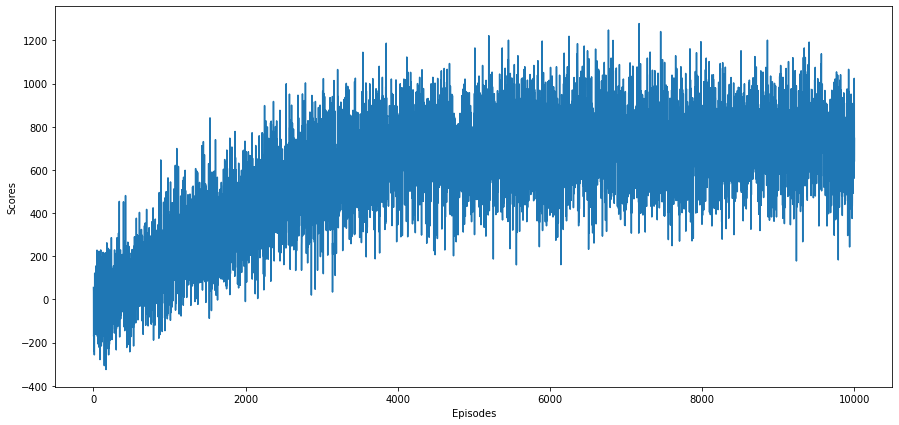

In [57]:
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.plot(scores)

#### Expected Reward converged to around 730

In [58]:
np.mean(scores[-2000:])

733.078

## Episode Generation


In [34]:
state_space,action_space,state = env.reset()
encoded_state = env.state_encod_arch2(state)
score=0
trajectory = ""
while env.time_elapsed <= 24*30:
    possible_actions_index,actions = env.requests(state)
    action = agent.get_action(encoded_state,possible_actions_index)
    
    next_state = env.next_state_func(state,action,Time_matrix)
    reward = env.reward_func(state,action,Time_matrix)
    encoded_next_state = env.state_encod_arch2(next_state)
    print("Current State: ",state, "Possible Actions: ", actions, "Action Chosen: ",action, state, "Reward:", reward)
    trajectory = trajectory + str(state) + ", " + str(action) + ", " + str(reward) + ", " + str(next_state) + "------> " 
    score += reward
    state = next_state

trajectory += str(state)
print("\n\nTotal Reward: ",score)
print(trajectory)

Current State:  [3, 6, 0] Possible Actions:  [[4, 1], [3, 1], [2, 4], [1, 2], [2, 0], [4, 3], [1, 3], [3, 2], [1, 4], [0, 3], [0, 4], [2, 1], [1, 0], [0, 0], [0, 0]] Action Chosen:  10 [3, 6, 0] Reward: 35.0
Current State:  [1, 17, 0] Possible Actions:  [[3, 1], [0, 3], [4, 3], [2, 1], [4, 0], [3, 0], [3, 2], [4, 1], [0, 0], [0, 0]] Action Chosen:  13 [1, 17, 0] Reward: -12.0
Current State:  [0, 23, 0] Possible Actions:  [[2, 4], [3, 2], [0, 0], [0, 0]] Action Chosen:  12 [0, 23, 0] Reward: -30.0
Current State:  [4, 5, 1] Possible Actions:  [[3, 0], [0, 0], [0, 0]] Action Chosen:  13 [4, 5, 1] Reward: 19.0
Current State:  [0, 12, 1] Possible Actions:  [[0, 2], [4, 0], [2, 4], [0, 0], [0, 0]] Action Chosen:  12 [0, 12, 1] Reward: -1.0
Current State:  [4, 14, 1] Possible Actions:  [[3, 0], [0, 4], [2, 0], [3, 2], [3, 4], [1, 3], [4, 3], [2, 4], [0, 0], [0, 0]] Action Chosen:  16 [4, 14, 1] Reward: 24.0
Current State:  [4, 20, 1] Possible Actions:  [[1, 4], [4, 0], [2, 3], [3, 0], [0, 2],

Current State:  [3, 2, 5] Possible Actions:  [[1, 3], [0, 3], [4, 0], [1, 2], [2, 3], [0, 0], [0, 0]] Action Chosen:  11 [3, 2, 5] Reward: 44.0
Current State:  [3, 13, 5] Possible Actions:  [[3, 1], [1, 4], [1, 2], [3, 4], [1, 0], [2, 0], [3, 0], [3, 2], [0, 4], [1, 3], [4, 1], [0, 1], [4, 2], [0, 3], [0, 0], [0, 0]] Action Chosen:  1 [3, 13, 5] Reward: 6.0
Current State:  [1, 19, 5] Possible Actions:  [[4, 2], [2, 3], [0, 4], [4, 0], [2, 1], [0, 3], [3, 4], [4, 1], [1, 4], [0, 1], [3, 2], [0, 0], [0, 0]] Action Chosen:  10 [1, 19, 5] Reward: 24.0
Current State:  [1, 1, 6] Possible Actions:  [[3, 4], [4, 2], [0, 1], [4, 0], [3, 1], [1, 4], [4, 1], [2, 4], [3, 2], [4, 3], [1, 2], [0, 3], [1, 3], [0, 0], [0, 0]] Action Chosen:  1 [1, 1, 6] Reward: 24.0
Current State:  [1, 7, 6] Possible Actions:  [[1, 4], [2, 1], [2, 0], [0, 3], [3, 2], [3, 1], [3, 4], [4, 3], [0, 4], [1, 0], [0, 2], [4, 2], [0, 1], [4, 0], [0, 0], [0, 0]] Action Chosen:  10 [1, 7, 6] Reward: 16.0
Current State:  [1, 11,